# 9.6.2_Support Vector Machine 

In [51]:
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve

from mlxtend.plotting import plot_decision_regions

import matplotlib.pyplot as plt
import seaborn as sns

## Generating toy dataset

In [7]:
#setting the seed 
X = np.random.normal(size = (200,2))
X[:100,] += 2
X[100:150,] -= 2
y = [0]*150 + [1]*50

data = pd.DataFrame({'X1':X[:,0],'X2':X[:,1],'y':y})
data.head()

,X1,X2,y
0,0.707018,3.407676,0
1,3.649701,2.818427,0
2,3.597445,2.494933,0
3,1.557623,2.569730,0
4,1.311609,0.670486,0


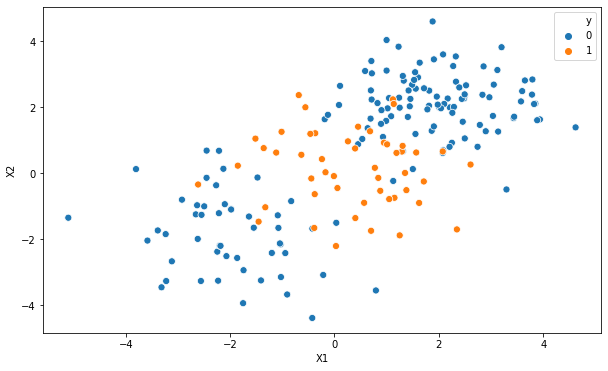

In [16]:
#plotting the data 
plt.figure(figsize = (10,6))
sns.scatterplot(x = 'X1',y = 'X2',hue = 'y',data = data,s = 50)

We can say that there is no possible linearly separation between the two classes

In [19]:
#splitting the data into train and test
X_train,X_test,y_train,y_test = train_test_split(data.drop('y',axis=1),data['y'],test_size = 0.5,random_state = 1)
print(X_train.shape,X_test.shape)

(100, 2) (100, 2)


## Fitting the model with radical kernal to training data

In [20]:
svm = SVC(kernel='rbf',gamma = 1,C = 1)
svm.fit(X_train,y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### Plotting the decision boundary

Text(0, 0.5, 'X2')

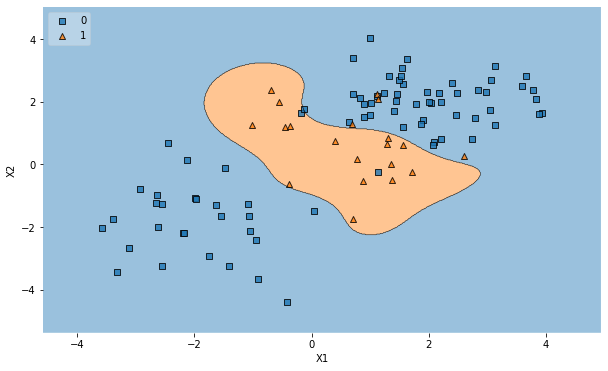

In [25]:
plt.figure(figsize = (10,6))
plot_decision_regions(np.array(X_train), np.array(y_train), clf=svm, legend=2)

plt.xlabel('X1')
plt.ylabel('X2')

In [30]:
print('Number of Support Vectors are ',svm.support_vectors_.shape[0])
print('Accuracy on training data is ',svm.score(X_train,y_train))

Number of Support Vectors are  54
Accuracy on training data is  0.94


## Choosing a high number of C

Number of Support Vectors are  18
Accuracy on training data is  1.0


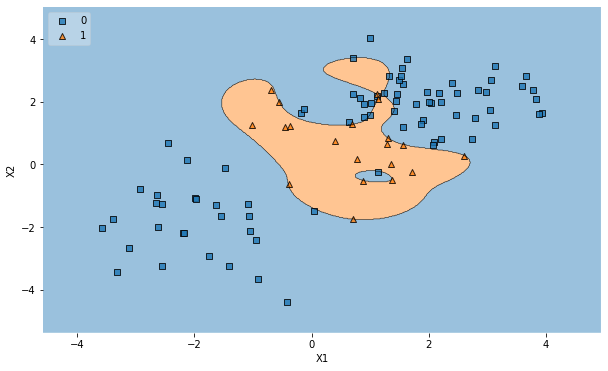

In [32]:
svm = SVC(kernel='rbf',gamma = 1,C = 10e5)
svm.fit(X_train,y_train)

### Plotting the decision boundary

plt.figure(figsize = (10,6))
plot_decision_regions(np.array(X_train), np.array(y_train), clf=svm, legend=2)

plt.xlabel('X1')
plt.ylabel('X2')

print('Number of Support Vectors are ',svm.support_vectors_.shape[0])
print('Accuracy on training data is ',svm.score(X_train,y_train))

Altough we are having a better training accuracy this time,but we can see that the model is overfitting the data, and it will perform poor on test data

## Choosing the optimal value of C and gamma using cross validation

In [34]:
params_dict = {'C':[0.1,1,10,100,1000],'gamma':[0.5,1,2,3,4]}
search = GridSearchCV(SVC(kernel = 'rbf'),params_dict,cv =10)
search.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.5, 1, 2, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [35]:
search.best_params_

{'C': 10, 'gamma': 0.5}

We can see that the values are different as compared to the one that we have in the book....and i hope that you know why it is happening that way...

In [36]:
best_model = search.best_estimator_

## Performance of best_model on test data

In [42]:
test_preds = best_model.predict(X_test)
print('Test accuracy is ',accuracy_score(y_test,test_preds))
print('Confusion matrix is - ')
print(confusion_matrix(y_test,test_preds))

Test accuracy is  0.84
Confusion matrix is - 
[[63  7]
 [ 9 21]]


# 9.6.3 ROC curves

In [96]:
def plot_roc(cls,X,y,title):
    probs = cls.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y,probs)
    auc = roc_auc_score(y,probs)
    
    plt.figure(figsize = (6,6))
    plt.plot(fpr,tpr,label="auc="+str(auc)[0:4],c = 'r')
    plt.plot([0,1],[0,1],alpha = 0.1,c = 'b')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()


In [97]:
#because we need probability = True to get probs
best_model.probability = True
best_model.gamma = 0.5
best_model.fit(X_train,y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

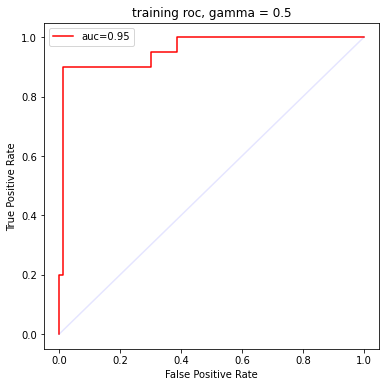

In [98]:
plot_roc(best_model,X_train,y_train,'training roc, gamma = 0.5')

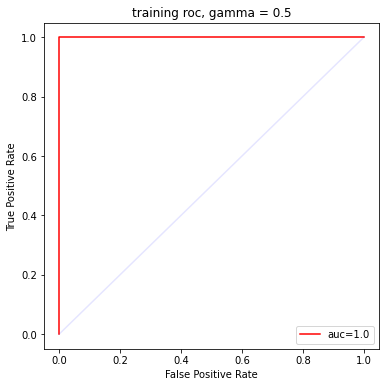

In [99]:
#roc curve if gamma is high
best_model.probability = True
best_model.gamma = 50
best_model.fit(X_train,y_train)

plot_roc(best_model,X_train,y_train,'training roc, gamma = 0.5')

woah...but wait, its training roc, not test roc :(

## Plotting the same on test data

In [100]:
def find_roc_terms(cls,X,y):
    probs = cls.predict_proba(X)[:,1]
    fpr,tpr,_ = roc_curve(y,probs)
    auc = roc_auc_score(y,probs)
    
    return fpr,tpr,auc

In [120]:
def plot_roc_test(cls,X_train,y_train,X_test,y_test):
    fpr,tpr,auc = find_roc_terms(cls,X_train,y_train)
    fpr_test,tpr_test,auc_test = find_roc_terms(cls,X_test,y_test)
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,6))
    ax1.plot(fpr,tpr,label="auc="+str(auc)[0:4],c = 'r')
    ax1.plot([0,1],[0,1],alpha = 0.1,c = 'b')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Train Roc')
    ax1.legend()
    
    ax2.plot(fpr_test,tpr_test,label="auc="+str(auc_test)[0:4],c = 'r')
    ax2.plot([0,1],[0,1],alpha = 0.1,c = 'b')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Test Roc')
    ax2.legend()


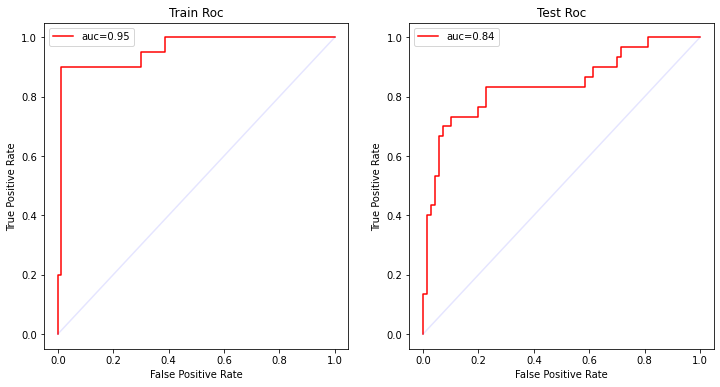

In [121]:
# for gamma = 0.5 
best_model.gamma = 0.5
best_model.fit(X_train,y_train)

plot_roc_test(best_model,X_train,y_train,X_test,y_test)

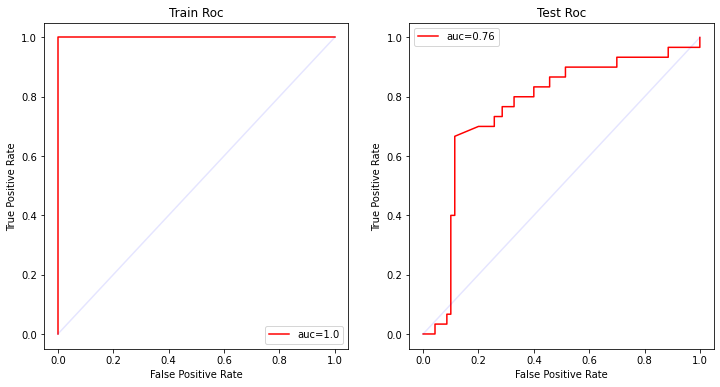

In [122]:
# for gamma = 50
best_model.gamma = 50
best_model.fit(X_train,y_train)

plot_roc_test(best_model,X_train,y_train,X_test,y_test)

we can infer from the last two graphs that model with gamma = 50, is highly overfitting the data